In [1]:
import pandas as pd
import talib

# データフレームを読み込む
df = pd.read_csv('USDJPY_1M_Pretty.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
# ATR20計算
df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=20)
del df['Volume']
df = df.dropna(how='any') # NaN行の削除
df.head()

,Open,High,Low,Close,ATR
Date,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031


In [6]:
import numpy as np
from numba import jit
import time

# TrailingStop
@jit
def buy_trail(data, index, price, atr):
    # TrailingStop: TP=ATR*5, SL=3*ATR, TS=ATR
    tp, sl, ts = price + 5 * atr, price - 3 * atr, price + atr
    for i in range(index, len(data)):
        row = data[i + 1]
        if row[2] <= tp <= row[1]: return tp
        elif row[2] <= sl <= row[1]: return sl
        elif row[2] <= ts <= row[1]: # Move TakeProfit & StopLoss
            tp, sl, ts = row[3] + 5 * atr, row[3] - 3 * atr, row[3] + atr
    return data[-1][3]

@jit
def sell_trail(data, index, price, atr):
    # TrailingStop: TP=ATR*5, SL=3*ATR, TS=ATR
    tp, sl, ts = price - 5 * atr, price + 3 * atr, price - atr
    for i in range(index, len(data)):
        row = data[i + 1]
        if row[2] <= tp <= row[1]: return tp
        elif row[2] <= sl <= row[1]: return sl
        elif row[2] <= ts <= row[1]: # Move TakeProfit & StopLoss
            tp, sl, ts = row[3] - 5 * atr, row[3] + 3 * atr, row[3] - atr
    return data[-1][3]

# Buy & TrailingStop
@jit
def buy(data):
    result = []
    for i in range(len(data)):
        # i番目の瞬間に買いを入れると仮定
        row = data[i]
        result.append(buy_trail(data, i, row[3], row[4]) - row[3]) # 買いを入れた結果（損益）を保存
    return result

# Sell & TrailingStop
@jit
def sell(data):
    result = []
    for i in range(len(data)):
        # i番目の瞬間に売りを入れると仮定
        row = data[i]
        result.append(sell_trail(data, i, row[3], row[4]) - row[3]) # 売りを入れた結果（損益）を保存
    return result

start = time.time()
buy_profit = np.array(buy(df.values))
print("Elapsed Time: {0} sec\nBuyProfits: {1}".format(time.time() - start, buy_profit))

start = time.time()
sell_profit = np.array(sell(df.values))
print("Elapsed Time: {0} sec\nSellProfits: {1}".format(time.time() - start, sell_profit))

Elapsed Time: 1.4574449062347412 sec
BuyProfits: [-0.0162   -0.01474  -0.033853 ... -0.039    -0.031     0.      ]
Elapsed Time: 1.6470015048980713 sec
SellProfits: [ 0.0342    0.03074   0.032853 ... -0.039    -0.031     0.      ]


In [7]:
# numpyデータをcsv化
val = df.values
size = val.shape[0]
data = np.zeros((size, 7))
for i in range(size):
    for x in range(5): data[i][x] = val[i][x]
    data[i][5] = buy_profit[i]
    data[i][6] = sell_profit[i]
csv = pd.DataFrame(index=df.index[:size], columns=['Open', 'High', 'Low', 'Close', 'ATR', 'Buy', 'Sell'], data=data)
csv.to_csv("USDJPY_TrailingStop.csv")
csv.head()

,Open,High,Low,Close,ATR,Buy,Sell
Date,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092


In [9]:
''' 損益結果をカテゴライズ '''
# 5つのパターン（0：大きな損失、1：小さな損失、2：損益なし、3：小さな利益、4：大きな利益）

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Ybuy = csv['Buy'].values.reshape(-1, 1)
scaler.fit(Ybuy)
Ybuy = scaler.transform(Ybuy)
Ybuy = np.floor(Ybuy * 5) # 5パターンにカテゴライズ
Ybuy = np.where(Ybuy == 5., 4., Ybuy) # 最大値が5になっているため4に直す
Ybuy

array([[2.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

<BarContainer object of 5 artists>

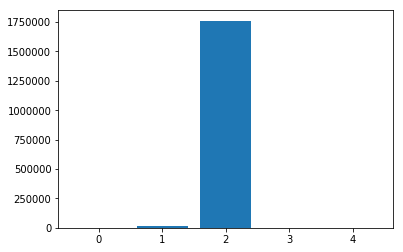

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Ynum = [len(Ybuy[Ybuy == i]) for i in range(5)]
plt.bar(range(5), Ynum)

<BarContainer object of 100 artists>

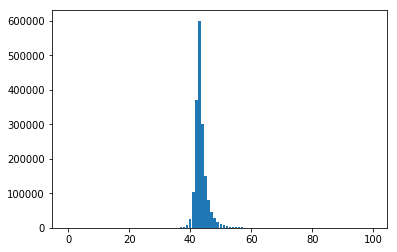

In [13]:
# 損益結果を100パターンに変換
scaler = MinMaxScaler()
Ybuy = csv['Buy'].values.reshape(-1, 1)
scaler.fit(Ybuy)
Ybuy = scaler.transform(Ybuy)
Ybuy = np.floor(Ybuy * 100)
Ybuy = np.where(Ybuy == 100., 99., Ybuy)
Ynum = [len(Ybuy[Ybuy == i]) for i in range(100)]
plt.bar(range(100), Ynum)

In [38]:
# 大きな損失と大きな利益を削除して、もう一度カテゴライズしてみる
scaler = MinMaxScaler()
Ybuy = csv['Buy'].values.reshape(-1, 1)
scaler.fit(Ybuy)
y = scaler.transform(Ybuy)
y = np.floor(y * 5) # 5パターンにカテゴライズ
y = np.where(y == 5., 4., y)
Ybuy = Ybuy[np.where((0 < y) & (y < 4))] # パターン1,2,3の列のみ抽出
Ybuy.shape, Ybuy

((1777487,), array([-0.0162  , -0.01474 , -0.033853, ..., -0.039   , -0.031   ,
         0.      ]))

In [39]:
y = Ybuy.reshape(-1, 1)
scaler.fit(y)
y = scaler.transform(y)
y = np.floor(y * 5) # 5パターンにカテゴライズ
y = np.where(y == 5., 4., y) # 最大値が5になっているため4に直す
y

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

<BarContainer object of 5 artists>

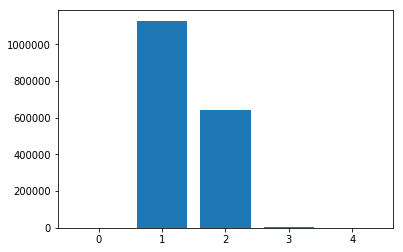

In [40]:
Ynum = [len(y[y == i]) for i in range(5)]
plt.bar(range(5), Ynum)

<BarContainer object of 5 artists>

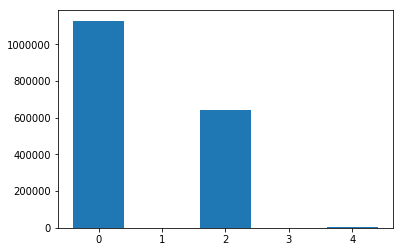

In [42]:
# さらに抽出して再カテゴライズ
Ybuy2 = y.reshape(-1, 1)
scaler.fit(Ybuy2)
y2 = scaler.transform(Ybuy2)
y2 = np.floor(y2 * 5)
y2 = np.where(y2 == 5., 4., y2)
Ybuy2 = Ybuy2[np.where((0 < y2) & (y2 < 4))] # パターン1,2,3の列のみ抽出

y2 = Ybuy2.reshape(-1, 1)
scaler.fit(y2)
y2 = scaler.transform(y2)
y2 = np.floor(y2 * 5)
y2 = np.where(y2 == 5., 4., y2)

Ynum = [len(y2[y2 == i]) for i in range(5)]
plt.bar(range(5), Ynum)

In [1]:
''' ATR値から損益額をカテゴライズ '''
import pandas as pd

# データフレームを読み込む
df = pd.read_csv('USDJPY_TrailingStop.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
df = df[(df['Buy'] != 0) & (df['Sell'] != 0)] # 損益額が0の行を削除
df.head()

,Open,High,Low,Close,ATR,Buy,Sell
Date,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092


In [2]:
import numpy as np

# 損益額を4パターン（2: 5*ATRより大きい, 1: 0より大きい, -1: 0より小さい, -2: -3*ATRより小さい）にカテゴライズ
df['Buy_cat'] = np.where(5 * df['ATR'] < df['Buy'], 2, np.where(0 < df['Buy'], 1, np.where(df['Buy'] < -3 * df['ATR'], -2, -1)))
df['Sell_cat'] = np.where(5 * df['ATR'] < df['Sell'], 2, np.where(0 < df['Sell'], 1, np.where(df['Sell'] < -3 * df['ATR'], -2, -1)))
df.to_csv('USDJPY_TrailingStop2.csv')
df.head()

,Open,High,Low,Close,ATR,Buy,Sell,Buy_cat,Sell_cat
Date,,,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200,-1,1
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740,-1,1
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853,-1,1
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360,-1,1
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092,-1,1


In [3]:
# Buy_catとSell_catの組み合わせから相場状況をカテゴライズ 
'''
相場状況=[Buy_cat, Sell_cat]
強い上昇相場(2) =[2, -2], [2, -1]
弱い上昇相場(1) =[1, -2], [1, -1]
レンジ相場(0)   =[2, 1], [2, 2], [1, 1], [1, 2], [-1, -2], [-1, -1], [-2, -2], [-2, -1]
弱い下降相場(-1)=[-2, 1], [-1, 1]
強い下降相場(-2)=[-2, 2], [-1, 2]
'''
df['Market'] = np.where(df['Buy_cat'] > 0, np.where(df['Sell_cat'] < 0, df['Buy_cat'], 0), np.where(df['Sell_cat'] > 0, -df['Sell_cat'], 0))
df.to_csv('USDJPY_TrailingStop2.csv')
df.head()

,Open,High,Low,Close,ATR,Buy,Sell,Buy_cat,Sell_cat,Market
Date,,,,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200,-1,1,-1
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740,-1,1,-1
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853,-1,1,-1
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360,-1,1,-1
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092,-1,1,-1


<BarContainer object of 5 artists>

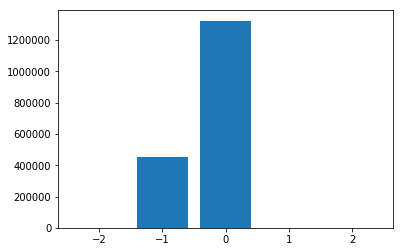

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# 相場状況の分散を確認
market = df['Market'].values
n = [len(market[market == i]) for i in range(-2, 3)]
plt.bar(range(-2, 3), n)

In [5]:
# 存在比率を確認
n / np.sum(n) * 100

array([3.26276755e-03, 2.54826083e+01, 7.44728380e+01, 2.66646865e-02,
       1.46261993e-02])

array([13.95862586, 48.27287088,  0.        , 27.45129476, 10.31720851])

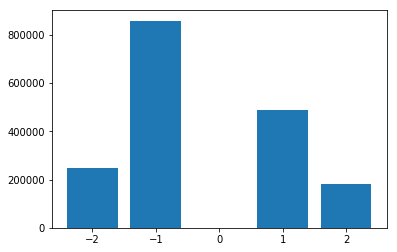

In [6]:
# 買いを入れた結果の分散を確認
buy = df['Buy_cat'].values
n = [len(buy[buy == i]) for i in range(-2, 3)]
plt.bar(range(-2, 3), n)
# 存在比率を確認
n / np.sum(n) * 100

損益をATR(20)比でカテゴライズした結果が、最もきれいに分散しているため、これを使って学習してみる。

In [8]:
import pandas as pd

# データフレームを読み込む
df = pd.read_csv('USDJPY_TrailingStop2.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
del df['ATR'], df['Open'], df['High'], df['Low'], df['Buy'], df['Sell'], df['Market']
# 特徴量、目的変数
x = df.loc[:, 'Close']
y_buy = df.loc[:, 'Buy_cat']
y_sell = df.loc[:, 'Sell_cat']
# 訓練データ、テストデータに分割
x_train, x_test = x[x.index < '2018'], x[x.index >= '2018']
y_buy_train, y_buy_test = y_buy[y_buy.index < '2018'], y_buy[y_buy.index >= '2018']
y_sell_train, y_sell_test = y_sell[y_sell.index < '2018'], y_sell[y_sell.index >= '2018']
y_buy_test

Date
2018-01-02 07:00:00    1
2018-01-02 07:01:00    1
2018-01-02 07:02:00   -2
2018-01-02 07:03:00    1
2018-01-02 07:04:00    1
2018-01-02 07:05:00    1
2018-01-02 07:06:00    1
2018-01-02 07:07:00    1
2018-01-02 07:08:00    1
2018-01-02 07:09:00    1
2018-01-02 07:10:00   -1
2018-01-02 07:11:00   -1
2018-01-02 07:12:00   -1
2018-01-02 07:13:00   -1
2018-01-02 07:14:00   -1
2018-01-02 07:15:00   -1
2018-01-02 07:16:00   -1
2018-01-02 07:17:00   -1
2018-01-02 07:18:00   -1
2018-01-02 07:19:00   -2
2018-01-02 07:20:00    1
2018-01-02 07:21:00    1
2018-01-02 07:22:00    1
2018-01-02 07:23:00    1
2018-01-02 07:24:00    1
2018-01-02 07:25:00    1
2018-01-02 07:26:00    1
2018-01-02 07:27:00    1
2018-01-02 07:28:00    1
2018-01-02 07:29:00    1
                      ..
2018-10-06 05:29:00    1
2018-10-06 05:30:00    1
2018-10-06 05:31:00    1
2018-10-06 05:32:00    1
2018-10-06 05:33:00    1
2018-10-06 05:34:00    1
2018-10-06 05:35:00    1
2018-10-06 05:36:00    1
2018-10-06 05:37:00 

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numba import jit
from keras.utils.np_utils import to_categorical

# 特徴量をClose(60)、目的変数をTrailingStop損益結果の4パターンとする
@jit
def gen_xy(x, y_buy, y_sell, window_len=60):
    X, Ybuy, Ysell = [], [], []
    for i in range(len(x) - window_len):
        X.append(x[i : i + window_len].copy())
        Ybuy.append(y_buy[i + window_len - 1])
        Ysell.append(y_sell[i + window_len - 1])
    X, Ybuy, Ysell = np.array(X), np.array(Ybuy), np.array(Ysell)
    # 特徴量を正規化
    scaler = MinMaxScaler()
    scaler.fit(X) # window_len区間の価格の最大値・最小値にフィット
    X = scaler.transform(X)
    # 目的変数を正規化
    Ybuy = np.where(Ybuy > 0, Ybuy + 1, Ybuy + 2)
    Ybuy = to_categorical(Ybuy.astype('int32'))
    Ysell = np.where(Ysell > 0, Ysell + 1, Ysell + 2)
    Ysell = to_categorical(Ysell.astype('int32'))
    return X, Ybuy, Ysell

Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values)
x_train.values.shape, x_train.values, Xtrain.shape, Xtrain, y_buy_train.values.shape, y_buy_train.values, Ytrain_buy.shape, Ytrain_buy

((1491718,),
 array([105.354, 105.355, 105.351, ..., 112.671, 112.668, 112.658]),
 (1491658, 60),
 array([[0.23275086, 0.23278836, 0.23263837, ..., 0.23316334, 0.23308835,
         0.23308835],
        [0.23278836, 0.23263837, 0.23278836, ..., 0.23308835, 0.23308835,
         0.23301335],
        [0.23263837, 0.23278836, 0.23316334, ..., 0.23308835, 0.23301335,
         0.23293835],
        ...,
        [0.50682466, 0.50701215, 0.50738713, ..., 0.50727464, 0.50734963,
         0.50719964],
        [0.50701215, 0.50738713, 0.50697465, ..., 0.50734963, 0.50719964,
         0.50712464],
        [0.50738713, 0.50697465, 0.50659967, ..., 0.50719964, 0.50712464,
         0.50701215]]),
 (1491718,),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 (1491658, 4),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=float32))

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

''' 買い専用AIの訓練 '''

model = Sequential()
model.add(LSTM(64, input_shape=(60, 1))) # 入力は 60期間分の値動き
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax')) # 出力は 損益額の4パターン
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="17.Buyer.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 60, 1), Ytrain_buy,
          batch_size=2048, # 訓練データが多い場合は、ミニバッチサイズを大きくしないとオーバーフローが起きる
          epochs=256,
          shuffle=True,
          validation_split=0.1, # 訓練データのうち10％を検証データとして仕様
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342492 samples, validate on 149166 samples
Epoch 1/256
1342492/1342492 [==============================] - 74s 55us/step - loss: 1.2207 - acc: 0.4813 - val_loss: 1.2114 - val_acc: 0.4877
Epoch 2/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.2174 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 3/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.2169 - acc: 0.4822 - val_loss: 1.2108 - val_acc: 0.4877
Epoch 4/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.2168 - acc: 0.4822 - val_loss: 1.2114 - val_acc: 0.4877
Epoch 5/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.2167 - acc: 0.4822 - val_loss: 1.2117 - val_acc: 0.4877
Epoch 6/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.2166 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 7/256
1342492/1342492 [==============================] - 69s 51us/step - loss: 1.21

In [14]:
# 特徴量を240期間にしてもう一度学習
Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values, 240)

model = Sequential()
model.add(LSTM(256, input_shape=(240, 1)))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="17.Buyer.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 240, 1), Ytrain_buy,
          batch_size=2048, # 訓練データが多い場合は、ミニバッチサイズを大きくしないとオーバーフローが起きる
          epochs=256,
          shuffle=True,
          validation_split=0.1, # 訓練データのうち10％を検証データとして仕様
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342330 samples, validate on 149148 samples
Epoch 1/256
1342330/1342330 [==============================] - 836s 623us/step - loss: 1.2198 - acc: 0.4816 - val_loss: 1.2141 - val_acc: 0.4876
Epoch 2/256
1342330/1342330 [==============================] - 833s 621us/step - loss: 1.2170 - acc: 0.4822 - val_loss: 1.2121 - val_acc: 0.4876
Epoch 3/256
1342330/1342330 [==============================] - 833s 620us/step - loss: 1.2168 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4876
Epoch 4/256
 188416/1342330 [===>..........................] - ETA: 11:24 - loss: 1.2180 - acc: 0.4806

KeyboardInterrupt: 

単純な値動きでの学習では、予測率50％を少し下回る程度の精度しか出せていない。

特徴量にテクニカル指標を採用するなど、いくらかの工夫が必要と思われる。

In [1]:
''' おまけ：CNNモデルで学習させてみる '''

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numba import jit
from keras.utils.np_utils import to_categorical

# データフレームを読み込む
df = pd.read_csv('USDJPY_TrailingStop2.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
del df['ATR'], df['Open'], df['High'], df['Low'], df['Buy'], df['Sell'], df['Market']
# 特徴量、目的変数
x = df.loc[:, 'Close']
y_buy = df.loc[:, 'Buy_cat']
y_sell = df.loc[:, 'Sell_cat']
# 訓練データ、テストデータに分割
x_train, x_test = x[x.index < '2018'], x[x.index >= '2018']
y_buy_train, y_buy_test = y_buy[y_buy.index < '2018'], y_buy[y_buy.index >= '2018']
y_sell_train, y_sell_test = y_sell[y_sell.index < '2018'], y_sell[y_sell.index >= '2018']

# 特徴量をClose(60)、目的変数をTrailingStop損益結果の4パターンとする
@jit
def gen_xy(x, y_buy, y_sell, window_len=60):
    X, Ybuy, Ysell = [], [], []
    for i in range(len(x) - window_len):
        X.append(x[i : i + window_len].copy())
        Ybuy.append(y_buy[i + window_len - 1])
        Ysell.append(y_sell[i + window_len - 1])
    X, Ybuy, Ysell = np.array(X), np.array(Ybuy), np.array(Ysell)
    # 特徴量を正規化
    scaler = MinMaxScaler()
    scaler.fit(X) # window_len区間の価格の最大値・最小値にフィット
    X = scaler.transform(X)
    # 目的変数を正規化
    Ybuy = np.where(Ybuy > 0, Ybuy + 1, Ybuy + 2)
    Ybuy = to_categorical(Ybuy.astype('int32'))
    Ysell = np.where(Ysell > 0, Ysell + 1, Ysell + 2)
    Ysell = to_categorical(Ysell.astype('int32'))
    return X, Ybuy, Ysell

Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values)
x_train.values.shape, x_train.values, Xtrain.shape, Xtrain, y_buy_train.values.shape, y_buy_train.values, Ytrain_buy.shape, Ytrain_buy

Using TensorFlow backend.


((1491718,),
 array([105.354, 105.355, 105.351, ..., 112.671, 112.668, 112.658]),
 (1491658, 60),
 array([[0.23275086, 0.23278836, 0.23263837, ..., 0.23316334, 0.23308835,
         0.23308835],
        [0.23278836, 0.23263837, 0.23278836, ..., 0.23308835, 0.23308835,
         0.23301335],
        [0.23263837, 0.23278836, 0.23316334, ..., 0.23308835, 0.23301335,
         0.23293835],
        ...,
        [0.50682466, 0.50701215, 0.50738713, ..., 0.50727464, 0.50734963,
         0.50719964],
        [0.50701215, 0.50738713, 0.50697465, ..., 0.50734963, 0.50719964,
         0.50712464],
        [0.50738713, 0.50697465, 0.50659967, ..., 0.50719964, 0.50712464,
         0.50701215]]),
 (1491718,),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 (1491658, 4),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=float32))

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

''' CNNで買い専用AIの訓練 '''

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', padding='valid', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="17.BuyerCNN.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 60, 1), Ytrain_buy,
          batch_size=2048, # 訓練データが多い場合は、ミニバッチサイズを大きくしないとオーバーフローが起きる
          epochs=256,
          shuffle=True,
          validation_split=0.1, # 訓練データのうち10％を検証データとして仕様
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342492 samples, validate on 149166 samples
Epoch 1/256
1342492/1342492 [==============================] - 13s 9us/step - loss: 1.2195 - acc: 0.4818 - val_loss: 1.2114 - val_acc: 0.4877
Epoch 2/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2170 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 3/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2167 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 4/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2167 - acc: 0.4822 - val_loss: 1.2110 - val_acc: 0.4877
Epoch 5/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2166 - acc: 0.4822 - val_loss: 1.2108 - val_acc: 0.4877
Epoch 6/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2166 - acc: 0.4822 - val_loss: 1.2110 - val_acc: 0.4877
Epoch 7/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2166 - acc: 0.4

In [3]:
Xtest, Ytest_buy, Ytest_sell = gen_xy(x_test.values, y_buy_test.values, y_sell_test.values)
model.evaluate(Xtest.reshape(Xtest.shape[0], 60, 1), Ytest_buy)

285854/285854 [==============================] - 12s 40us/step


[1.2152179759775485, 0.4825855156840822]

CNNを使ってもLSTMを使ってもあまり変わらない。

In [4]:
''' 目的変数を勝てる・負けるの2パターンにして学習させてみる '''

@jit
def gen_xy(x, y_buy, y_sell, window_len=60):
    X, Ybuy, Ysell = [], [], []
    for i in range(len(x) - window_len):
        X.append(x[i : i + window_len].copy())
        Ybuy.append(y_buy[i + window_len - 1])
        Ysell.append(y_sell[i + window_len - 1])
    X, Ybuy, Ysell = np.array(X), np.array(Ybuy), np.array(Ysell)
    # 特徴量を正規化
    scaler = MinMaxScaler()
    scaler.fit(X) # window_len区間の価格の最大値・最小値にフィット
    X = scaler.transform(X)
    # 目的変数を正規化
    Ybuy = np.where(Ybuy > 0, 1, 0)
    Ybuy = to_categorical(Ybuy.astype('int32'))
    Ysell = np.where(Ysell > 0, 1, 0)
    Ysell = to_categorical(Ysell.astype('int32'))
    return X, Ybuy, Ysell

Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values)

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', padding='valid', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="17.Buyer2.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 60, 1), Ytrain_buy,
          batch_size=2048,
          epochs=256,
          shuffle=True,
          validation_split=0.1,
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342492 samples, validate on 149166 samples
Epoch 1/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6637 - acc: 0.6217 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 2/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6619 - val_acc: 0.6245
Epoch 3/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6620 - val_acc: 0.6245
Epoch 4/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6620 - val_acc: 0.6245
Epoch 5/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 6/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 7/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.62

In [5]:
Xtest, Ytest_buy, Ytest_sell = gen_xy(x_test.values, y_buy_test.values, y_sell_test.values)
model.evaluate(Xtest.reshape(Xtest.shape[0], 60, 1), Ytest_buy)

285854/285854 [==============================] - 12s 41us/step


[0.6626681952004024, 0.6228879078143305]

勝つ・負けるの2択なら62％の精度で予測できることが分かった。

それでも、十分な精度とは言えないため、特徴量にテクニカル指標を採用するなど、いくらかの工夫が必要と思われる。